# Task 1 - Data exploration and preparation (4 marks)

### Download the Intel Image Classification dataset and unzip it: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

### You will observe that the data is already partitioned into training and test set (ignore the folder called "seg_pred"), and that the files are arranged by folders.

# 1.1 Exploration (2 marks)



In [169]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [111]:

import tensorflow as tf
from tensorflow.keras import layers, models
import keras_tuner as kt

In [113]:


# Define the base paths
base_train_path = '/Users/priyamsinha/Downloads/archive/seg_train/seg_train/'

base_test_path = '/Users/priyamsinha/Downloads/archive/seg_test/seg_test/'

# Define the function to rename and move images
def rename_and_move_images(base_path, target_folder):
    # Create the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    
    # Iterate over each category folder
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        if os.path.isdir(category_path):
            # Iterate over each image in the category
            for idx, filename in enumerate(os.listdir(category_path), start=1):
                if filename.endswith('.jpg'):
                    new_filename = f'{category}_{str(idx).zfill(3)}.jpg'  # Example: 01_001.jpg
                    source_file = os.path.join(category_path, filename)
                    target_file = os.path.join(target_folder, new_filename)
                    
                    # Move and rename the file
                    shutil.move(source_file, target_file)
                    print(f'Moved and renamed {filename} to {new_filename}')

# Run the function for train and test sets
rename_and_move_images(base_train_path, '/Users/priyamsinha/Downloads/archive/train/')
rename_and_move_images(base_test_path, '/Users/priyamsinha/Downloads/archive/test/')



## Write code that does the following tasks:

## (1 mark) Assign the list of available classes to a variable with name CLASS_NAMES. For each class name, display one image and print the dimensions of the corresponding numpy array.




The Following are the 6 class names ['mountain', 'sea', 'buildings', 'glacier', 'forest', 'street']


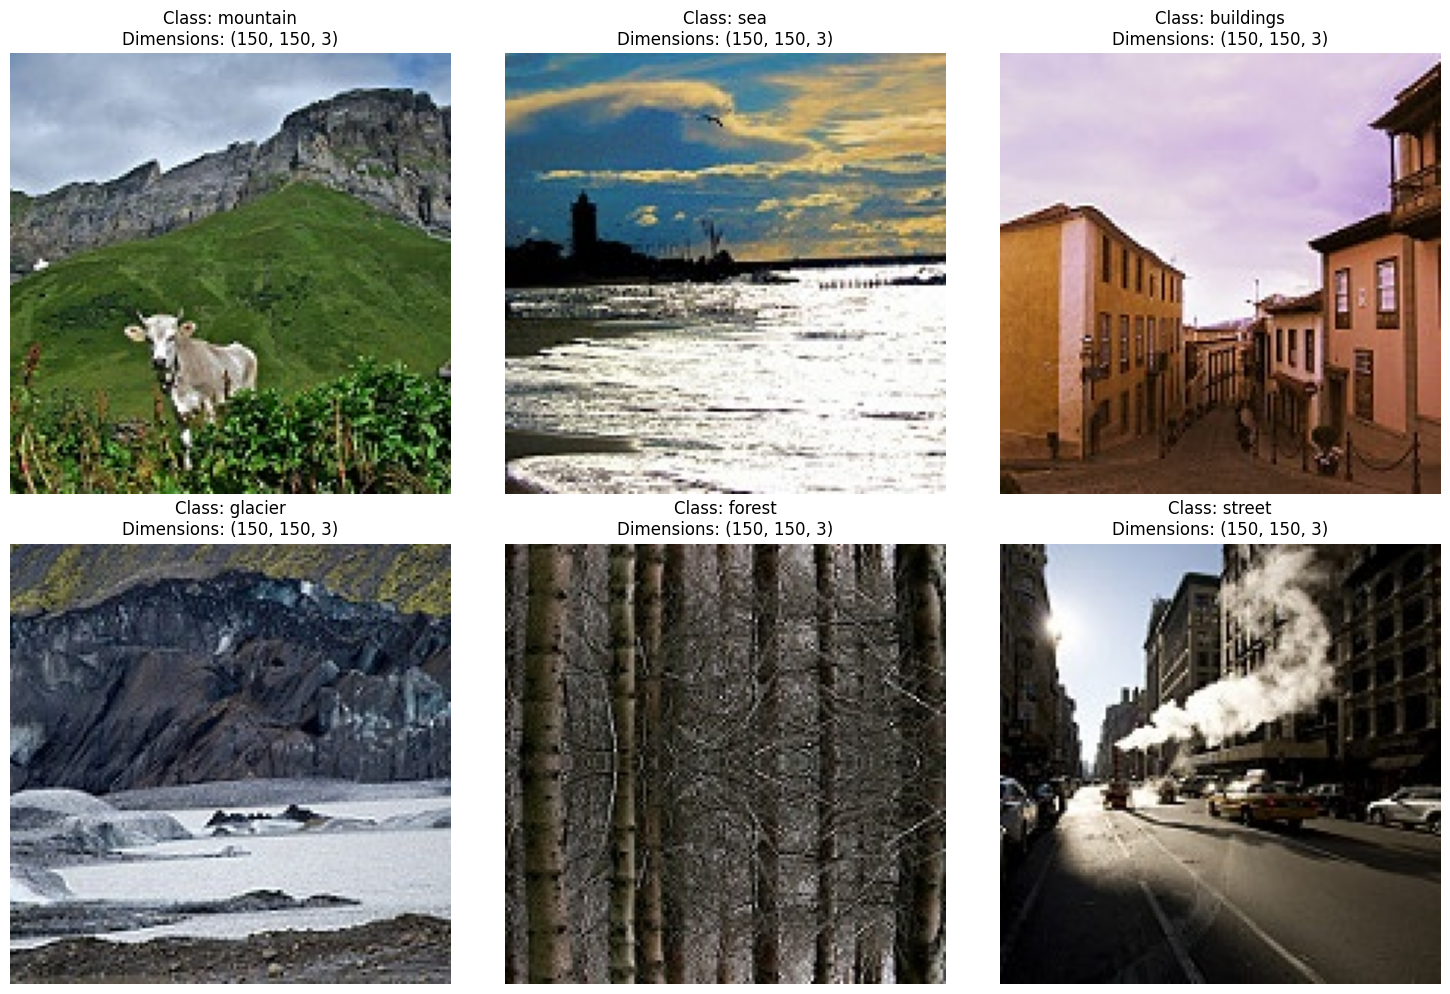

In [114]:


# Path to your image folder
train_path = '/Users/priyamsinha/Downloads/archive/train/'

# Extract class names
CLASS_NAMES = list(set([filename.split('_')[0] for filename in os.listdir(train_path) if filename.endswith('.jpg')]))
print(f'The Following are the 6 class names {CLASS_NAMES}')

# Set up the plot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns for 6 classes
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

# Display one image per class with label
for i, class_name in enumerate(CLASS_NAMES):
    # Find one image corresponding to the class
    for filename in os.listdir(train_path):
        if filename.startswith(class_name) and filename.endswith('.jpg'):
            # Load the image
            image_path = os.path.join(train_path, filename)
            image = Image.open(image_path)
            
            # Convert image to NumPy array
            image_array = np.array(image)
            
            # Display the image
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {class_name}\nDimensions: {image_array.shape}")
            axes[i].axis('off')  # Hide the axes
            
            # Break after displaying one image for this class
            break

# Adjust layout
plt.tight_layout()
plt.show()


## (1 mark) Determine the number of images in the training and test sets for each class name. Are there any significant differences between the proportions of images in the training and test sets?

In [115]:
def extract_labels(path):
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.jpg'):
         label = filename.split('_')[0]  # Extract the label
         labels.append(label)
    
    df = pd.DataFrame(labels, columns=['Label'])
    freq_table = df['Label'].value_counts().reset_index()
    freq_table.columns = ['Label', 'Count']
    total = freq_table['Count'].sum()
    freq_table['Proportion'] = round((freq_table['Count'] / total) * 100)

# Calculate the total count and add it as a row
    total_row = pd.DataFrame([['Total', freq_table['Count'].sum()]], columns=['Label', 'Count'])
    freq_table = pd.concat([freq_table, total_row], ignore_index=True)

    return freq_table


# Print the frequency table
print(f'Train Data set has the following distribiution of labels: \n {extract_labels('/Users/priyamsinha/Downloads/archive/train/')}')
print(f'Test Data set has the following distribiution of labels: \n {extract_labels('/Users/priyamsinha/Downloads/archive/test/')}')
print(f'The split between the train and test {(3000/17034) * 100 } %')



Train Data set has the following distribiution of labels: 
        Label  Count  Proportion
0   mountain   2512        18.0
1    glacier   2404        17.0
2     street   2382        17.0
3        sea   2274        16.0
4     forest   2271        16.0
5  buildings   2191        16.0
6      Total  14034         NaN
Test Data set has the following distribiution of labels: 
        Label  Count  Proportion
0    glacier    553        18.0
1   mountain    525        18.0
2        sea    510        17.0
3     street    501        17.0
4     forest    474        16.0
5  buildings    437        15.0
6      Total   3000         NaN
The split between the train and test 17.611835153222966 %


### There are no significant differences between the proportions of images in the training and test sets. The distribution of labels is well balanced across the two sets, meaning the dataset has been split in a consistent and proportional manner, allowing for a fair evaluation during model training and testing.


## 1.2 Preparation (2 marks)

### Use TensorFlow's image_dataset_from_directory to generate datasets for training, validation, and test. Make sure that you set the following options:

In [221]:

image_size = (150, 150)
batch_size = 32
seed = 1234


In [223]:
CLASS_NAMES

['mountain', 'sea', 'buildings', 'glacier', 'forest', 'street']

In [222]:
# Training Dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/priyamsinha/Downloads/Dataset/seg_train/seg_train',
    validation_split=0.2,
    labels = 'inferred',
    subset= "training",
    seed= 1234,
    image_size= (150,150),
    batch_size = 32,
    color_mode='rgb',
    shuffle=True,
    label_mode='categorical',  
    class_names=CLASS_NAMES
)

# Validation Dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '/Users/priyamsinha/Downloads/Dataset/seg_train/seg_train',
    validation_split=0.2,
    labels = 'inferred',
    subset= "validation",
    seed= 1234,
    image_size= (150,150),
    batch_size = 32,
    color_mode='rgb',
    shuffle=True,
    label_mode='categorical',  
    class_names=CLASS_NAMES
)
# Test Dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/Users/priyamsinha/Downloads/Dataset/seg_test/seg_test',
    labels = 'inferred',
    seed= 1234,
    image_size= (150,150),
    batch_size = 32,
    color_mode='rgb',
    shuffle=True,
    label_mode='categorical',  
    class_names=CLASS_NAMES
)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.


['mountain', 'sea', 'buildings', 'glacier', 'forest', 'street']

### Make sure that the image data are normalised between the values 0 and 1 

 ### refrence from https://stackoverflow.com/questions/63572451/normalizing-batchdataset-in-tensorflow-2-3

In [119]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label


train_dataset = train_dataset.map(process)
val_dataset = val_dataset.map(process)
test_dataset = test_dataset.map(process)


In [120]:
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(images[0])

(32, 150, 150, 3)
tf.Tensor(
[[[0.8        0.827451   0.8666667 ]
  [0.8        0.827451   0.8666667 ]
  [0.79607844 0.8235294  0.8627451 ]
  ...
  [0.8117647  0.80784315 0.827451  ]
  [0.8117647  0.80784315 0.827451  ]
  [0.8117647  0.80784315 0.827451  ]]

 [[0.7921569  0.81960785 0.85882354]
  [0.7921569  0.81960785 0.85882354]
  [0.79607844 0.8235294  0.8627451 ]
  ...
  [0.8039216  0.8        0.81960785]
  [0.80784315 0.8039216  0.8235294 ]
  [0.80784315 0.8039216  0.8235294 ]]

 [[0.78039217 0.80784315 0.84705883]
  [0.78431374 0.8117647  0.8509804 ]
  [0.7921569  0.81960785 0.85882354]
  ...
  [0.8117647  0.80784315 0.827451  ]
  [0.8117647  0.80784315 0.827451  ]
  [0.8156863  0.8117647  0.83137256]]

 ...

 [[0.26666668 0.44313726 0.45490196]
  [0.27058825 0.44705883 0.45882353]
  [0.2784314  0.4509804  0.45490196]
  ...
  [0.35686275 0.52156866 0.5176471 ]
  [0.3529412  0.5176471  0.5137255 ]
  [0.34509805 0.50980395 0.5058824 ]]

 [[0.2627451  0.4392157  0.4509804 ]
  [0.266

2024-09-06 11:12:52.204646: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Task 2 - A Simple Classifier (6 marks)

## 2.1 First classifier (2 marks)



In [180]:
# Assume the number of classes in your dataset
num_classes = len(CLASS_NAMES)

# Build the model
model_first = models.Sequential([
    layers.Flatten(input_shape=(150, 150, 3)),  # Flatten the input
    layers.Dense(128, activation='relu'),       # Fully connected layer
    layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation
])

# Compile the model
model_first.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
              metrics=['accuracy'])

# Summary of the model
model_first.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,640,902 (32.96 MB)

 Trainable params: 8,640,902 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

### I have included Early stopping with validation loss starting from epoch 2

In [181]:
# Train the model with validation
model_first_save = model_first.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Number of epochs can be adjusted
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, mode = "auto", start_from_epoch = 2 )  
    ]
)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.3437 - loss: 7.0317 - val_accuracy: 0.3567 - val_loss: 2.3634
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.4182 - loss: 1.6617 - val_accuracy: 0.4027 - val_loss: 1.4861
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4399 - loss: 1.4087 - val_accuracy: 0.4982 - val_loss: 1.3258
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4666 - loss: 1.3625 - val_accuracy: 0.4498 - val_loss: 1.4648
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4683 - loss: 1.3797 - val_accuracy: 0.4754 - val_loss: 1.4005
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.4675 - loss: 1.3403 - val_accuracy: 0.4619 - val_loss: 1.3700
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4671 - loss: 1.3232 - val_accuracy: 0.3610 - val_loss: 1.5128


In [129]:
# Evaluate the model on the test dataset
test_loss, test_acc = model_first.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5172 - loss: 1.3417
Test accuracy: 0.5160
Test loss: 1.3345


## The test accuracy with a simple classifier model is 51.60%

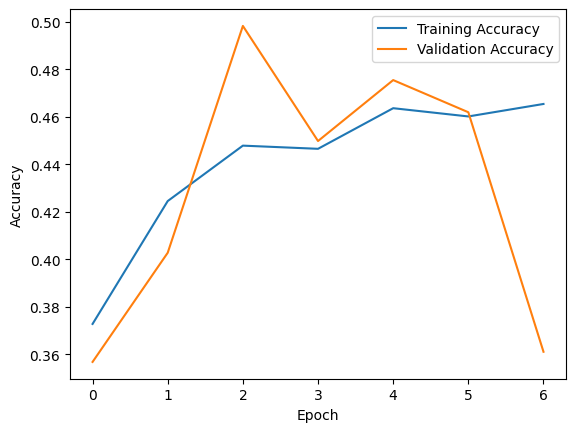

In [182]:
# Plot accuracy
plt.plot(model_first_save.history['accuracy'], label='Training Accuracy')
plt.plot(model_first_save.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## 2.2 A more complex classifier (2 marks)

In [196]:
def build_model(hp):
    model = models.Sequential()
    
    # Flatten the input
    model.add(layers.Flatten(input_shape=(150, 150, 3)))
    
    # Tune the number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=256, step= 32 ),
                               activation='relu'))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.3, step=0.1)))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(
                  learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3])),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of different models to try
    executions_per_trial=3,  # Number of times to try each model
    directory='my_dir',
    project_name='intro_to_kt14'
)

# Perform the search
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=2)
])


# Get the best model
best_model_complex = tuner.get_best_models(num_models=1)[0]


# Evaluate the model on the test dataset
test_loss, test_acc = best_model_complex.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Trial 5 Complete [00h 13m 37s]
val_accuracy: 0.5357567071914673

Best val_accuracy So Far: 0.569612721602122
Total elapsed time: 00h 39m 16s
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5750 - loss: 1.1379
Test accuracy: 0.5747
Test loss: 1.1472


Epoch 1/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.6175 - loss: 1.0416 - val_accuracy: 0.5745 - val_loss: 1.1131
Epoch 2/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6330 - loss: 1.0058 - val_accuracy: 0.5798 - val_loss: 1.1176
Epoch 3/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.6356 - loss: 0.9899 - val_accuracy: 0.5916 - val_loss: 1.0920
Epoch 4/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6507 - loss: 0.9691 - val_accuracy: 0.5677 - val_loss: 1.1146
Epoch 5/5
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.6530 - loss: 0.9571 - val_accuracy: 0.5820 - val_loss: 1.0896
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5896 - loss: 1.1031
Test accuracy: 0.5867
Test loss: 1.1137


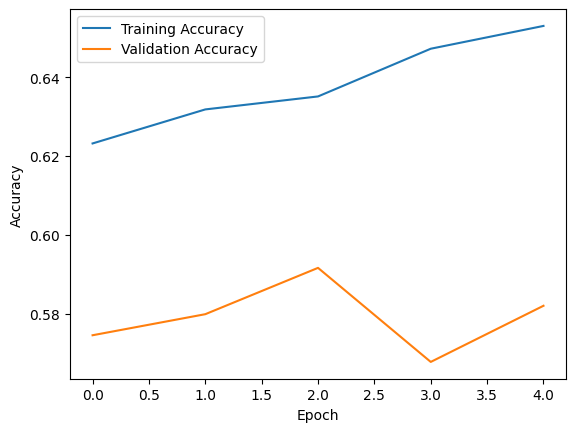

In [199]:
best_model_save = best_model_complex.fit(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
])
# Evaluate the model on the test dataset
test_loss, test_acc = best_model_complex.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
# Plot accuracy
plt.plot(best_model_save.history['accuracy'], label='Training Accuracy')
plt.plot(best_model_save.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




## Test accuracy with hyperparameter training: 0.5867

In [212]:
best_model_complex.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │    15,120,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,364,724 (173.05 MB)

 Trainable params: 15,121,574 (57.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,243,150 (115.37 MB)

## 2.3 Error analysis (2 marks)

## Evaluate your best-performing system from task 2.2 against the system of task 2.1. In separate text cells of your Jupyter notebook, answer the following questions and justify the answer.





In [226]:
# Get the best hyperparameters after the search
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:\n", best_hyperparameters.values)


Best Hyperparameters:
 {'filters_1': 128, 'kernel_size_1': 5, 'filters_2': 256, 'kernel_size_2': 3, 'dense_units': 64, 'learning_rate': 0.001}


## Model 1 
- **Total Parameters**: 8,640,902  
- **Accuracy**: 51.60%  
- **Architecture Summary**: This model consists of a simple structure with one flattening layer followed by a dense layer with 128 units and the output layer with 6 units.

## Model 2 
- **Total Parameters**: 15,121,574  
- **Accuracy**: 58.67%  
- **Architecture Summary**: This model includes a larger dense layer with 224 units, followed by a dropout layer (likely for regularization), and the output layer with 6 units. The use of dropout might contribute to better generalization, thus yielding better accuracy.

## Comparison

### Model Complexity:
- **Model 2** has a larger dense layer with more parameters (15.1 million) compared to **Model 1** (8.6 million), which is likely contributing to the higher accuracy of **58.67%** in Model 2.  
- The **dropout layer** in Model 2 helps prevent overfitting, which likely improved performance slightly.

### Accuracy:
- **Model 2** achieves better accuracy (**58.67%**) compared to **Model 1** (**51.60%**). The addition of the larger dense layer and dropout in Model 2 likely helps the model capture more complex patterns.

### Hyperparameter-Tuned Model:
- The best hyperparameters (filters, kernel sizes, and dense units) suggest using convolutional layers (though not specified in the two models provided). These hyperparameters would likely yield even better performance because they introduce feature extraction capabilities with convolution filters and potentially better regularization with dense units and learning rate.

## Conclusion
- **Model 2** outperforms **Model 1** by about 7% in accuracy due to the more complex architecture and the addition of dropout for regularization.  
- The hyperparameter-tuned model suggests a convolutional architecture, which could likely lead to further improvements by extracting hierarchical features and making the model more robust for complex patterns.


## Which system had a lower degree of overfitting?




Based on the comparison of the two models:

- **Model 1** has an accuracy of **51.60%** with fewer parameters (8.6 million). It likely did not overfit much because it has a simpler architecture and moderate performance on the dataset.
  
- **Model 2** has an accuracy of **58.67%** with a much larger number of parameters (15.1 million) and includes a dropout layer to prevent overfitting. While it performs better, its complexity suggests a higher risk of overfitting.

### Conclusion:
**Model 1** likely had a **lower degree of overfitting** because it has a simpler architecture with fewer parameters. Although **Model 2** has better performance, its increased complexity suggests a higher likelihood of overfitting, even though the dropout layer helps mitigate this.


## Task 3 - A more complex classifier (6 marks)

## Task 3.1 Using ConvNets (2 marks)



In [197]:
model_conv = models.Sequential()

# First Convolutional Block
model_conv.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_conv.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model_conv.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flattening Layer
model_conv.add(layers.Flatten())

# Fully Connected Layer
model_conv.add(layers.Dense(128, activation='relu'))

# Output Layer
model_conv.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model_conv
model_conv.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model_conv.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,126 (40.58 MB)

 Trainable params: 10,637,126 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [155]:
model_conv_save = model_conv.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
])
test_loss, test_acc = model_conv.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 79s 223ms/step - accuracy: 0.5109 - loss: 1.7324 - val_accuracy: 0.7181 - val_loss: 0.7682
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - accuracy: 0.7307 - loss: 0.7283 - val_accuracy: 0.7431 - val_loss: 0.6978
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 227ms/step - accuracy: 0.7745 - loss: 0.6110 - val_accuracy: 0.7498 - val_loss: 0.6939
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.8627 - loss: 0.3905 - val_accuracy: 0.6999 - val_loss: 0.9632
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.9213 - loss: 0.2362 - val_accuracy: 0.7594 - val_loss: 0.9292
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 87s 246ms/step - accuracy: 0.9577 - loss: 0.1309 - val_accuracy: 0.7602 - val_loss: 0.9024
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7548 - loss: 0.9246
Test accuracy: 0.7560
Test loss: 0.9239


## The CNN has given accuracy on the test data set as 75.60%

## Use reasonable numbers for the hyperparameters (number of filters, kernel size, pool size, activation, etc), and justify your choice

In [206]:


def build_model(hp):
    model = models.Sequential()

    # First Conv2D layer with MaxPooling2D
    model.add(layers.Conv2D(
        filters=hp.Int('filters_1', min_value=64, max_value= 256, step=64), 
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5, 7]), 
        activation='relu', 
        input_shape=(150, 150, 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Second Conv2D layer with MaxPooling2D
    model.add(layers.Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64), 
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5, 7]), 
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output and add a Dense layer
    model.add(layers.Flatten())
    model.add(layers.Dense(hp.Int('dense_units', min_value=64, max_value=128, step=64), activation='relu'))

    # Output layer for classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(
                   learning_rate = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [207]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Number of different models to try
    executions_per_trial=2,  # Number of times to try each model
    directory='my_dir',
    project_name='cnn_hyperparam_tuning5'
)


In [227]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Number of different models to try
    executions_per_trial=2,  # Number of times to try each model
    directory='my_dir',
    project_name='cnn_hyperparam_tuning'
)


In [ ]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=5, callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
])


In [209]:
# Retrieve the best model after hyperparameter tuning
best_model_conv = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
test_loss, test_acc = best_model_conv.evaluate(test_dataset)
print(f"Best Model - Test accuracy: {test_acc:.4f}")
print(f"Best Model - Test loss: {test_loss:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 440ms/step - accuracy: 0.7212 - loss: 0.7367
Best Model - Test accuracy: 0.7287
Best Model - Test loss: 0.7415


The Hyperparameter model had accuraucy of 72.87% with an complex architecture

In [220]:
best_model_conv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 71, 71, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 313600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    20,070,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,375,750 (77.73 MB)

 Trainable params: 20,375,750 (77.73 MB)

 Non-trainable params: 0 (0.00 B)

## Task 3.2 Using pre-trained models (2 marks)

## Use MobileNet, pre-trained on imagenet as discussed in the lectures. Add the correct classification layer, and train it with your data. Make sure that you freeze MobileNet's weights during training.

In [184]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [213]:
# Load the MobileNet model with pre-trained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model's weights
base_model.trainable = False


In [214]:
# Create a new model on top of the base model
model_pretrain = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),  # Increased units
    layers.Dropout(0.5),  # Add dropout to prevent overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Final classification layer
])


In [247]:

base_model.trainable = False
model_pretrain.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = model_pretrain.fit(train_dataset, validation_data=val_dataset, epochs=10)

base_model.trainable = True

model_pretrain.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history_fine = model_pretrain.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - accuracy: 0.5311 - loss: 1.7951 - val_accuracy: 0.6522 - val_loss: 1.0173
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 133ms/step - accuracy: 0.6711 - loss: 0.9131 - val_accuracy: 0.6850 - val_loss: 0.8689
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 136ms/step - accuracy: 0.7083 - loss: 0.7807 - val_accuracy: 0.6981 - val_loss: 0.8044
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - accuracy: 0.7331 - loss: 0.7138 - val_accuracy: 0.7092 - val_loss: 0.7623
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 48s 138ms/step - accuracy: 0.7501 - loss: 0.6601 - val_accuracy: 0.7231 - val_loss: 0.7335
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.7635 - loss: 0.6257 - val_accuracy: 0.7316 - val_loss: 0.7109
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 134ms/step - accuracy: 0.7737 - loss: 0.5974 - val_accuracy: 0.7384 - val_loss: 0.6975
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - accuracy: 0.7811 - loss: 0

Task 3.3 Comparative evaluation (2 marks)

Compare the evaluation results of the best systems from tasks 3.1 and 3.2 and answer the following questions.

Display the confusion matrix generated by the best system on the test set. For this you can use, for example, TensorFlow's confusion_matrix.
Identify the most commont type of classification error reported by the confusion matrix, and display 5 images from the test set that have this classification error.


In [251]:

test_loss_custom, test_acc_custom = best_model_conv.evaluate(test_dataset)
print(f"Custom CNN - Test accuracy: {test_acc_custom:.4f}")


test_loss_mobilenet, test_acc_mobilenet = model_pretrain.evaluate(test_dataset)
print(f"MobileNet - Test accuracy: {test_acc_mobilenet:.4f}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 426ms/step - accuracy: 0.6772 - loss: 125.9543
Custom CNN - Test accuracy: 0.6843
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.9148 - loss: 0.3354
MobileNet - Test accuracy: 0.9110


## The best system is the pre_Trained model as per the accuracy on the test data set

In [254]:
y_pred = model_pretrain.predict(test_dataset)

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step


In [258]:
# Extract true labels from the test dataset
all_labels = []
for _, labels in test_dataset:
    all_labels.append(labels.numpy())  # Convert to NumPy array

# Concatenate the labels into a single array
y_true = np.concatenate(all_labels)

# Convert the true labels to class indices (if they are one-hot encoded)
y_true_classes = np.argmax(y_true, axis=1)

# Display the true classes
print(y_true_classes[:10])  # Print first 10 true labels


[2 2 5 5 4 5 1 0 2 3]


94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step


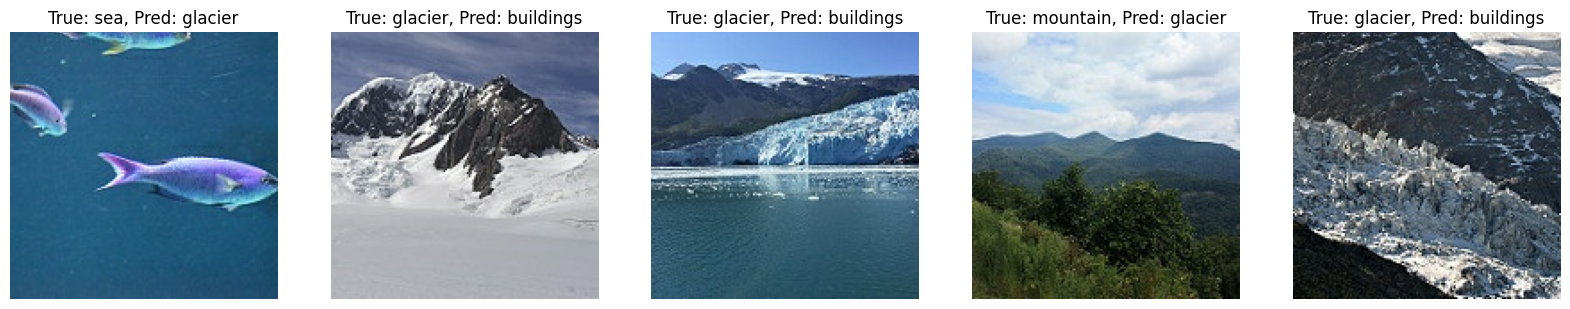

In [265]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Convert the dataset into NumPy arrays
all_images = []
all_labels = []
for images, labels in test_dataset:
    all_images.append(images.numpy())  # Convert images to NumPy array
    all_labels.append(labels.numpy())  # Convert labels to NumPy array

# Concatenate the arrays to get the full dataset
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

# Convert the predictions to class indices
y_pred = model_pretrain.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels to class indices
y_true_classes = np.argmax(all_labels, axis=1)

# Find misclassified indices
misclassified_indices = np.where(y_true_classes != y_pred_classes)[0]

# Display 5 misclassified images
plt.figure(figsize=(20, 20))
for i, idx in enumerate(misclassified_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(all_images[idx].astype("uint8"))
    plt.title(f"True: {CLASS_NAMES[y_true_classes[idx]]}, Pred: {CLASS_NAMES[y_pred_classes[idx]]}")
    plt.axis('off')
plt.show()


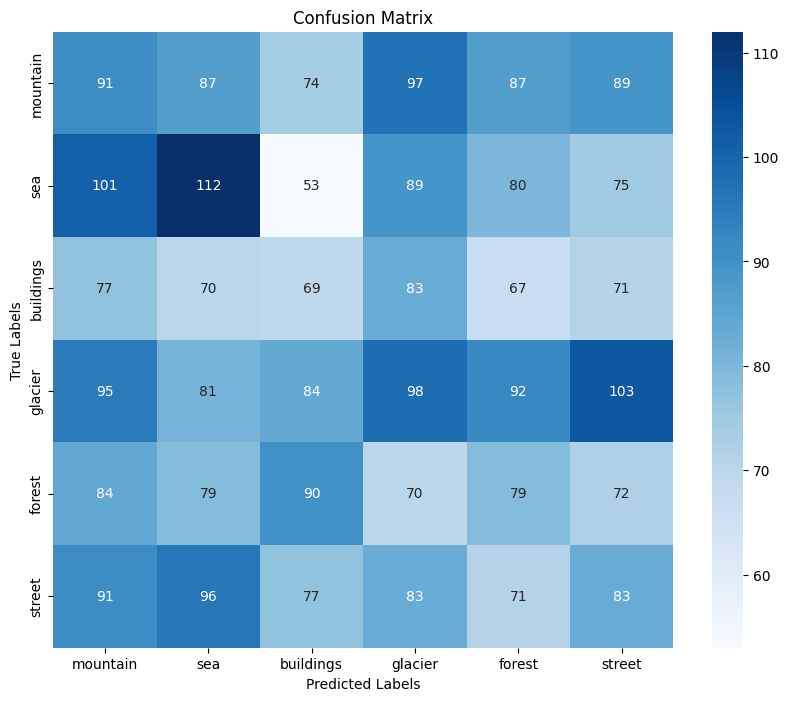

In [264]:


from sklearn.metrics import confusion_matrix, accuracy_score

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print or visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
